## 매개변수 갱신

확률적 경사 하강법(SGD)

In [ ]:
class SGD:
    def __init__(self, lr):
        self.lr = lr
    
    def update(self, params, grads):
        for key in params.keys():
            params[key] -= self.lr * grads[key]

모멘텀

In [1]:
import numpy as np

In [2]:
class Momentum:
    def __init__(self, lr=0.01, momentum=0.9):
        self.lr = lr
        self.momentum = momentum
        self.v = None
    
    def update(self, params, grads):
        if self.v is None:
            self.v = {}
            for key, val in params.items():
                self.v[key] = np.zeros_like(val)
            
        for key in params.keys():
            self.v[key] = self.momentum*self.v[key] - self.lr*grads[key]
            params[key] += self.v[key]

AdaGrad

In [ ]:
class Adagrad:
    def __init__(self, lr=0.01, ):
        self.lr = lr
        self.epsilon = 1e-7
        self.h = None
    
    def update(self, params, grads):
        if self.h == None:
            self.h = {}
            for key in params.keys():
                self.h[key] = np.zeros_like(grads[key])
        
        for key in params.keys():
            self.h[key] += grads[key] * grads[key]
            grads[key] -= self.lr * grads[key] / (np.sqrt(self.h[key]) + self.epsilon)

Adam

In [ ]:
class Adam:
    def __init__(self, lr=0.001, beta1=0.9, beta2=0.999):
        self.lr = lr
        self.beta1 = beta1
        self.beta2 = beta2
        self.iter = 0
        self.m = None
        self.v = None

    def update(self, params, grads):
        if self.m is None:
            self.m, self.v = {}, {}
            for key, value in params.items():
                self.m[key] = np.zeros_like(value)
                self.v[key] = np.zeros_like(value)
            
        self.iter += 1
        lr_t = self.lr * np.sqrt(1.0 - self.beta2**self.iter) / (1.0 - self.beta1**self.iter)
        for key in params.keys():
            self.m[key] += (1-self.beta1) * (grads[key] - self.m[key]) 
            self.v[key] += (1-self.beta2) * (grads[key]**2 - self.v[key])

        params[key] -= lr_t * self.m[key] / (np.sqrt(self.v[key]) + 1e-7)


## 가중치의 초깃값

은닉층의 활성화값 분포

In [3]:
import numpy as np
import matplotlib.pyplot as plt

def sigmoid(x):
    return 1 / (1 + np.exp(-x))

x = np.random.randn(1000, 100)
node_num = 100
hidden_layer_size = 5
activations = {}

for i in range(hidden_layer_size):
    if i != 0:
        x = activations[i-1]
    
    w = np.random.randn(node_num, node_num) * 1
    a = np.dot(x, w)
    z = sigmoid(a)
    activations[i] = z

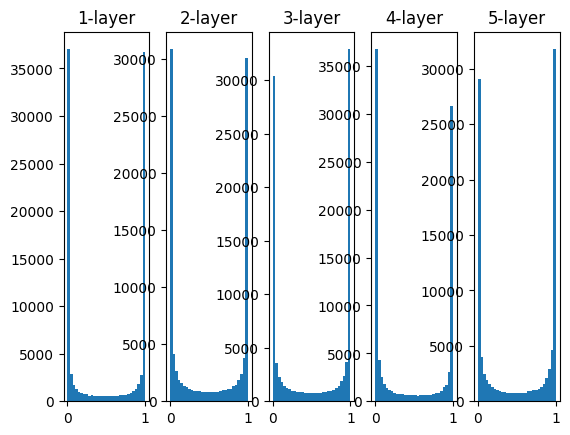

In [5]:
for i, a in activations.items():
    plt.subplot(1, len(activations), i+1)
    plt.title(str(i+1) + "-layer")
    plt.hist(a.flatten(), 30, range=(0,1))
plt.show()

In [6]:
import numpy as np
import matplotlib.pyplot as plt

def sigmoid(x):
    return 1 / (1 + np.exp(-x))

x = np.random.randn(1000, 100)
node_num = 100
hidden_layer_size = 5
activations = {}

for i in range(hidden_layer_size):
    if i != 0:
        x = activations[i-1]
    
    w = np.random.randn(node_num, node_num) * 0.01
    a = np.dot(x, w)
    z = sigmoid(a)
    activations[i] = z

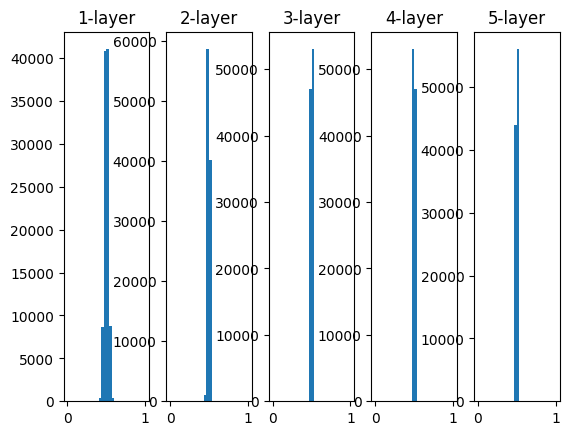

In [7]:
for i, a in activations.items():
    plt.subplot(1, len(activations), i+1)
    plt.title(str(i+1) + "-layer")
    plt.hist(a.flatten(), 30, range=(0,1))
plt.show()

Xavier

In [12]:
import numpy as np
import matplotlib.pyplot as plt

def sigmoid(x):
    return 1 / (1 + np.exp(-x))

x = np.random.randn(1000, 100)
node_num = 100
hidden_layer_size = 5
activations = {}

for i in range(hidden_layer_size):
    if i != 0:
        x = activations[i-1]
    
    w = np.random.randn(node_num, node_num) / np.sqrt(node_num)
    a = np.dot(x, w)
    z = sigmoid(a)
    activations[i] = z

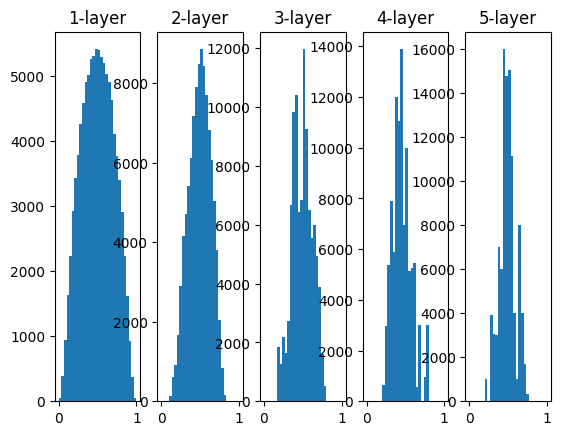

In [13]:
for i, a in activations.items():
    plt.subplot(1, len(activations), i+1)
    plt.title(str(i+1) + "-layer")
    plt.hist(a.flatten(), 30, range=(0,1))
plt.show()

일그러짐 개선 ## 책에서는 Note로 표기

In [31]:
import numpy as np
import matplotlib.pyplot as plt

def tanh(x):
    return (np.exp(x) - np.exp(-x)) / (np.exp(x) + np.exp(-x) + 1e-4)

x = np.random.randn(1000, 100)
node_num = 100
hidden_layer_size = 5
activations = {}

for i in range(hidden_layer_size):
    if i != 0:
        x = activations[i-1]
    
    w = np.random.randn(node_num, node_num) / np.sqrt(node_num)
    a = np.dot(x, w)
    z = tanh(a)
    activations[i] = z

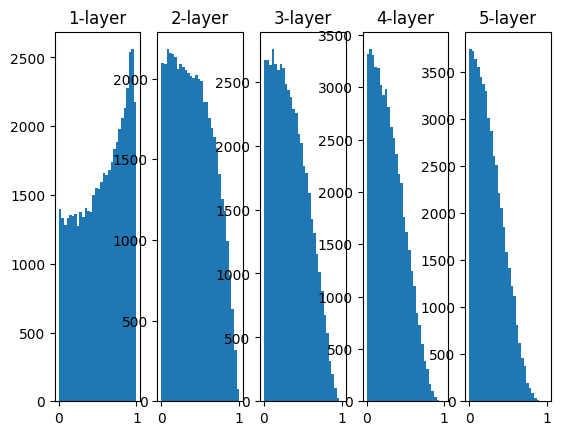

In [32]:
for i, a in activations.items():
    plt.subplot(1, len(activations), i+1)
    plt.title(str(i+1) + "-layer")
    plt.hist(a.flatten(), 30, range=(0,1))
plt.show()

## 6.4 바른 학습을 위해

오버피팅

In [1]:
from dataset.mnist import load_mnist

(x_train, t_train), (x_test, t_test) = load_mnist(normalize=True)

x_train = x_train[:300]
t_train = t_train[:300]

In [44]:
# coding: utf-8
import sys, os
sys.path.append(os.pardir)  # 부모 디렉터리의 파일을 가져올 수 있도록 설정
import numpy as np
from collections import OrderedDict
from common.layers import *
from common.gradient import numerical_gradient


class MultiLayerNetDrop:
    """완전연결 다층 신경망

    Parameters
    ----------
    input_size : 입력 크기（MNIST의 경우엔 784）
    hidden_size_list : 각 은닉층의 뉴런 수를 담은 리스트（e.g. [100, 100, 100]）
    output_size : 출력 크기（MNIST의 경우엔 10）
    activation : 활성화 함수 - 'relu' 혹은 'sigmoid'
    weight_init_std : 가중치의 표준편차 지정（e.g. 0.01）
        'relu'나 'he'로 지정하면 'He 초깃값'으로 설정
        'sigmoid'나 'xavier'로 지정하면 'Xavier 초깃값'으로 설정
    weight_decay_lambda : 가중치 감소(L2 법칙)의 세기
    """
    def __init__(self, input_size, hidden_size_list, output_size,
                 activation='relu', weight_init_std='relu', weight_decay_lambda=0, dropout_ratio=0.1):
        self.input_size = input_size
        self.output_size = output_size
        self.hidden_size_list = hidden_size_list
        self.hidden_layer_num = len(hidden_size_list)
        self.weight_decay_lambda = weight_decay_lambda
        self.params = {}

        # 가중치 초기화
        self.__init_weight(weight_init_std)

        # 계층 생성
        activation_layer = {'sigmoid': Sigmoid, 'relu': Relu}
        self.layers = OrderedDict()
        for idx in range(1, 4):
            self.layers['Affine' + str(idx)] = Affine(self.params['W' + str(idx)],
                                                      self.params['b' + str(idx)])
            self.layers['Activation_function' + str(idx)] = activation_layer[activation]()            

        for idx in range(4, self.hidden_layer_num + 1):
            self.layers['Affine' + str(idx)] = Affine(self.params['W' + str(idx)],
                                                      self.params['b' + str(idx)])
            self.layers['Activation_function' + str(idx)] = activation_layer[activation]()
            self.layers['Dropout' + str(idx)] = Dropout(dropout_ratio)  # Dropout 레이어 추가

        idx = self.hidden_layer_num + 1
        self.layers['Affine' + str(idx)] = Affine(self.params['W' + str(idx)],
            self.params['b' + str(idx)])

        self.last_layer = SoftmaxWithLoss()

    def __init_weight(self, weight_init_std):
        """가중치 초기화
        
        Parameters
        ----------
        weight_init_std : 가중치의 표준편차 지정（e.g. 0.01）
            'relu'나 'he'로 지정하면 'He 초깃값'으로 설정
            'sigmoid'나 'xavier'로 지정하면 'Xavier 초깃값'으로 설정
        """
        all_size_list = [self.input_size] + self.hidden_size_list + [self.output_size]
        for idx in range(1, len(all_size_list)):
            scale = weight_init_std
            if str(weight_init_std).lower() in ('relu', 'he'):
                scale = np.sqrt(2.0 / all_size_list[idx - 1])  # ReLU를 사용할 때의 권장 초깃값
            elif str(weight_init_std).lower() in ('sigmoid', 'xavier'):
                scale = np.sqrt(1.0 / all_size_list[idx - 1])  # sigmoid를 사용할 때의 권장 초깃값
            self.params['W' + str(idx)] = scale * np.random.randn(all_size_list[idx-1], all_size_list[idx])
            self.params['b' + str(idx)] = np.zeros(all_size_list[idx])

    def predict(self, x, train_flg=False):
        for layer in self.layers.values():
            if isinstance(layer, Dropout):
                x = layer.forward(x, train_flg)
            else:
                x = layer.forward(x)

        return x

    def loss(self, x, t, train_flg=False):
        """손실 함수를 구한다.
        
        Parameters
        ----------
        x : 입력 데이터
        t : 정답 레이블 
        
        Returns
        -------
        손실 함수의 값
        """
        y = self.predict(x, train_flg)

        weight_decay = 0
        for idx in range(1, self.hidden_layer_num + 2):
            W = self.params['W' + str(idx)]
            weight_decay += 0.5 * self.weight_decay_lambda * np.sum(W ** 2)

        return self.last_layer.forward(y, t) + weight_decay

    def accuracy(self, x, t, train_flg=False):
        y = self.predict(x, train_flg)
        y = np.argmax(y, axis=1)
        if t.ndim != 1 : t = np.argmax(t, axis=1)

        accuracy = np.sum(y == t) / float(x.shape[0])
        return accuracy

    def numerical_gradient(self, x, t):
        """기울기를 구한다(수치 미분).
        
        Parameters
        ----------
        x : 입력 데이터
        t : 정답 레이블
        
        Returns
        -------
        각 층의 기울기를 담은 딕셔너리(dictionary) 변수
            grads['W1']、grads['W2']、... 각 층의 가중치
            grads['b1']、grads['b2']、... 각 층의 편향
        """
        loss_W = lambda W: self.loss(x, t)

        grads = {}
        for idx in range(1, self.hidden_layer_num+2):
            grads['W' + str(idx)] = numerical_gradient(loss_W, self.params['W' + str(idx)])
            grads['b' + str(idx)] = numerical_gradient(loss_W, self.params['b' + str(idx)])

        return grads

    def gradient(self, x, t):
        """기울기를 구한다(오차역전파법).

        Parameters
        ----------
        x : 입력 데이터
        t : 정답 레이블
        
        Returns
        -------
        각 층의 기울기를 담은 딕셔너리(dictionary) 변수
            grads['W1']、grads['W2']、... 각 층의 가중치
            grads['b1']、grads['b2']、... 각 층의 편향
        """
        # forward
        self.loss(x, t, train_flg=True)

        # backward
        dout = 1
        dout = self.last_layer.backward(dout)

        layers = list(self.layers.values())
        layers.reverse()
        for layer in layers:
            dout = layer.backward(dout)

        # 결과 저장
        grads = {}
        for idx in range(1, self.hidden_layer_num+2):
            grads['W' + str(idx)] = self.layers['Affine' + str(idx)].dW + self.weight_decay_lambda * self.layers['Affine' + str(idx)].W
            grads['b' + str(idx)] = self.layers['Affine' + str(idx)].db

        return grads



In [49]:
from common.multi_layer_net import MultiLayerNet
from common.optimizer import SGD

network = MultiLayerNetDrop(input_size=784, hidden_size_list=[100, 100, 100, 100, 100, 100], output_size=10, dropout_ratio=0.3)
optimizer = SGD(lr=0.01)
max_epochs = 201
train_size = x_train.shape[0]
batch_size = 100

train_loss_list = []
train_acc_list_drop_3 = []
test_acc_list_drop_3 = []

iter_per_epoch = max(train_size / batch_size, 1)
epoch_cnt = 0

for i in range(10000000):
    batch_mask = np.random.choice(train_size, batch_size)
    x_batch = x_train[batch_mask]
    t_batch = t_train[batch_mask]

    grads = network.gradient(x_batch, t_batch)
    optimizer.update(network.params, grads)

    if i % iter_per_epoch == 0:
        train_acc = network.accuracy(x_train, t_train, train_flg=False)
        test_acc = network.accuracy(x_test, t_test, train_flg=False)
        train_acc_list_drop_3.append(train_acc)
        test_acc_list_drop_3.append(test_acc)

        epoch_cnt += 1
        if epoch_cnt >= max_epochs:
            break

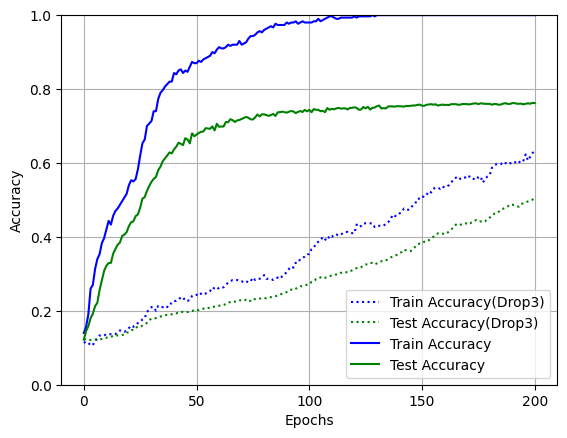

In [50]:
import matplotlib.pyplot as plt

epochs = range(0, 201)

plt.plot(epochs, train_acc_list_drop_3, color='blue', label='Train Accuracy(Drop3)', linestyle=':')
plt.plot(epochs, test_acc_list_drop_3, color='green', label='Test Accuracy(Drop3)', linestyle=':')
# plt.plot(epochs, train_acc_list_drop_2, color='blue', label='Train Accuracy(Drop2)', linestyle=':')
# plt.plot(epochs, test_acc_list_drop_2, color='green', label='Test Accuracy(Drop2)', linestyle=':')
# plt.plot(epochs, train_acc_list_drop_1, color='blue', label='Train Accuracy(Drop1)', linestyle=':')
# plt.plot(epochs, test_acc_list_drop_1, color='green', label='Test Accuracy(Drop1)', linestyle=':')
plt.plot(epochs, train_acc_list, color='blue', label='Train Accuracy')
plt.plot(epochs, test_acc_list, color='green', label='Test Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.xticks(range(0, 201, 50))
plt.yticks([0.0, 0.2, 0.4, 0.6, 0.8, 1.0])
plt.ylim(0.0, 1.0)
plt.grid(True)
plt.legend()
plt.show()

In [9]:
from common.multi_layer_net import MultiLayerNet
from common.optimizer import SGD

network = MultiLayerNet(input_size=784, hidden_size_list=[100, 100, 100, 100, 100, 100], output_size=10)
optimizer = SGD(lr=0.01)
max_epochs = 201
train_size = x_train.shape[0]
batch_size = 100

train_loss_list = []
train_acc_list = []
test_acc_list = []

iter_per_epoch = max(train_size / batch_size, 1)
epoch_cnt = 0

for i in range(10000000):
    batch_mask = np.random.choice(train_size, batch_size)
    x_batch = x_train[batch_mask]
    t_batch = t_train[batch_mask]

    grads = network.gradient(x_batch, t_batch)
    optimizer.update(network.params, grads)

    if i % iter_per_epoch == 0:
        train_acc = network.accuracy(x_train, t_train)
        test_acc = network.accuracy(x_test, t_test)
        train_acc_list.append(train_acc)
        test_acc_list.append(test_acc)

        epoch_cnt += 1
        if epoch_cnt >= max_epochs:
            break

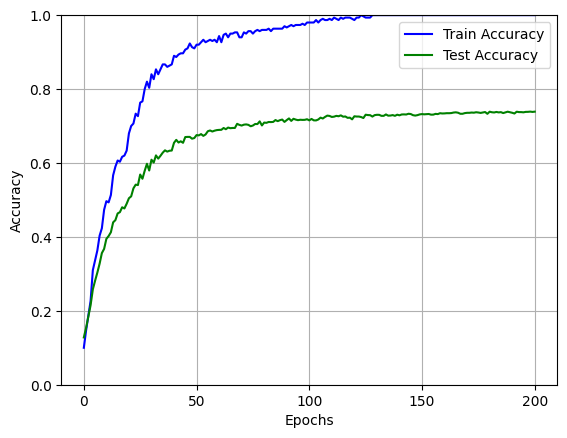

In [48]:
import matplotlib.pyplot as plt

epochs = range(0, 201)

plt.plot(epochs, train_acc_list, color='blue', label='Train Accuracy')
plt.plot(epochs, test_acc_list, color='green', label='Test Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.xticks(range(0, 201, 50))
plt.yticks([0.0, 0.2, 0.4, 0.6, 0.8, 1.0])
plt.ylim(0.0, 1.0)
plt.grid(True)
plt.legend()
plt.show()


드롭아웃

In [ ]:
class Dropout:
    def __init__(self, dropout_ratio=0.5):
        self.dropout_ratio = dropout_ratio
        self.mask = None

    def forward(self, x, train_flg=True):
        if train_flg:
            self.mask = np.random.rand(*x.shape) > self.dropout_ratio
            return x * self.mask
        else:
            return x * (1.0 - self.dropout_ratio) ## 추론 시에는 모든 노드로 연산을 수행하되, 드롭아웃 비율만큼 전체 연산 결과 크기를 줄여줌

    def backward(self, dout):
        return dout * self.mask

## 적절한 하이퍼파라미터 값 찾기

검증 데이터

In [49]:
from dataset.mnist import load_mnist
# from common.util import shuffle_dataset

In [51]:
def shuffle_dataset(x, t):
    permutation = np.random.permutation(x.shape[0])
    x = x[permutation, :] if x.ndim == 2 else x[permutation, :,:,:]
    t = t[permutation]
    
    return x, t

In [52]:
(x_train, t_train), (x_test, t_test) = load_mnist()
x_train, t_train = shuffle_dataset(x_train, t_train)

validation_rate = 0.20
validation_num = int(x_train.shape[0] * validation_rate)

x_val = x_train[:validation_num]
t_val = x_train[:validation_num]
x_train = x_train[validation_num:]
t_train = t_train[validation_num:]